In [1]:
import numpy as np
import bitshuffle.h5
import copy
# import scipy.io
import os
import sys
import h5py
from scipy.ndimage import gaussian_filter as gfdd
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
from scipy.special import erf
import warnings
warnings.filterwarnings('ignore')
import time

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [42]:
# import those necessary files and scripts
work_dir = "/sf/maloja/data/p19750/work/scripts"
sys.path.append(work_dir)
import CMC
import bad_pixel
import parameters
import find_center

In [14]:
from matplotlib import colors

def display_images(images, titles = None, Left_Annotate = None, images_per_row=20, dpi = None, fig_name = 'displayed_images'):
    """
    Display images in a grid, with a specified number of images per row.

    Parameters:
    images (ndarray): The ndarray containing the images, with shape (n, height, width).
    images_per_row (int): The number of images to display per row.
    """
    num_images = images.shape[0]
    num_cols = images_per_row
    num_rows = int(np.ceil(num_images / num_cols))

    # Create a figure with the specified size
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(52, num_rows * 4))

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    # Iterate through images and plot them
    for i in range(num_images):
        # max_val = np.log(np.max(images[i])+1)
        max_val = 1.5

        # Create a custom colormap that transitions from white to 'jet' at a threshold of 0.5

        # Define the threshold below which the color should be white
        threshold = 0.15
        
        # Create a new colormap that combines white for values below 0.5 and jet for the rest
        # Get the jet colormap
        jet = plt.cm.get_cmap('plasma', 256)
        
        # Create a new colormap by modifying the jet colormap
        # We combine white for values below 0.5 with the jet colormap
        new_colors = jet(np.linspace(0, 1, 256))  # Create a list of 256 colors from the jet colormap
        
        # Modify the colormap so that the first quarter (below 0.5) is white
        new_colors[:int(threshold * 256)] = [1, 1, 1, 1]  # Set the colors below the threshold to white (RGBA)
        
        # Create the new colormap
        new_cmap = colors.ListedColormap(new_colors)
        
        # Now apply this new colormap to your imshow plot
        axes[i].imshow(np.log(images[i] + 1), cmap=new_cmap, vmin=-(1/7)*max_val, vmax=max_val)
        if titles:
            axes[i].set_title(f'index = {i}; {titles[i]}')
        else:
            axes[i].set_title(f'index = {i}')
        axes[i].axis('off')  # Hide axes for better visualization
        if Left_Annotate and i % images_per_row == 0:
            axes[i].annotate(f'{Left_Annotate[i//10]}', xy=(-0.4,0.5), xycoords='axes fraction', fontsize=16, color='black', ha='left', va='bottom')
    
    # Hide any remaining empty subplots
    for i in range(num_images, num_rows * num_cols):
        axes[i].axis('off')
    
    plt.subplots_adjust(top=0.95, bottom=0.05, left=-0.01, right=1.01, hspace=0.4, wspace=0.3)
    # Adjust layout
    plt.tight_layout()
    plt.savefig(fig_name, dpi=dpi)
    plt.show()

def special_display_images(images, titles = None, Left_Annotate = None, images_per_row=20, dpi = None, fig_name = 'displayed_images'):
    """
    Display images in a grid, with a specified number of images per row.

    Parameters:
    images (ndarray): The ndarray containing the images, with shape (n, height, width).
    images_per_row (int): The number of images to display per row.
    """
    num_cols = images_per_row
    num_rows = images.shape[0]

    # Create a figure with the specified size
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(images_per_row*3, num_rows * 4))

    # # Flatten axes array for easy iteration
    # axes = axes.flatten()

    # Iterate through images and plot them
    for i in range(num_rows):
        for j in range(images[i].shape[0]):
            # max_val = np.log(np.max(images[i])+1)
            max_val = 1.5
    
            # Create a custom colormap that transitions from white to 'jet' at a threshold of 0.5
    
            # Define the threshold below which the color should be white
            threshold = 0.15
            
            # Create a new colormap that combines white for values below 0.5 and jet for the rest
            # Get the jet colormap
            jet = plt.cm.get_cmap('plasma', 256)
            
            # Create a new colormap by modifying the jet colormap
            # We combine white for values below 0.5 with the jet colormap
            new_colors = jet(np.linspace(0, 1, 256))  # Create a list of 256 colors from the jet colormap
            
            # Modify the colormap so that the first quarter (below 0.5) is white
            new_colors[:int(threshold * 256)] = [1, 1, 1, 1]  # Set the colors below the threshold to white (RGBA)
            
            # Create the new colormap
            new_cmap = colors.ListedColormap(new_colors)
            
            # Now apply this new colormap to your imshow plot
            axes[i][j].imshow(np.log(images[i][j] + 1), cmap=new_cmap, vmin=-(1/7)*max_val, vmax=max_val)
            if titles:
                axes[i][j].set_title(f'index = ({i},{j}); {titles[i][j]}')
            else:
                axes[i][j].set_title(f'index = ({i},{j})')
            axes[i][j].axis('off')  # Hide axes for better visualization
            if Left_Annotate:
                axes[i][0].annotate(f'{Left_Annotate[i]}', xy=(-0.4,0.5), xycoords='axes fraction', fontsize=16, color='black', ha='left', va='bottom')
        
        # Hide any remaining empty subplots
        for j in range(images[i].shape[0], num_cols):
            axes[i][j].axis('off')
    
    plt.subplots_adjust(top=0.95, bottom=0.05, left=-0.01, right=1.01, hspace=0.4, wspace=0.3)
    # Adjust layout
    plt.tight_layout()

    plt.savefig(fig_name, dpi=dpi)
    plt.show()


    
def display_image(image, title):
    
    fig = plt.figure(figsize = (14,14))
    max_val = 3
    # Create a custom colormap that transitions from white to 'jet' at a threshold of 0.5

    # Define the threshold below which the color should be white
    threshold = 0.15
    
    # Create a new colormap that combines white for values below 0.5 and jet for the rest
    # Get the jet colormap
    jet = plt.cm.get_cmap('plasma', 256)
    
    # Create a new colormap by modifying the jet colormap
    # We combine white for values below 0.5 with the jet colormap
    new_colors = jet(np.linspace(0, 1, 256))  # Create a list of 256 colors from the jet colormap
    
    # Modify the colormap so that the first quarter (below 0.5) is white
    new_colors[:int(threshold * 256)] = [1, 1, 1, 1]  # Set the colors below the threshold to white (RGBA)
    
    # Create the new colormap
    new_cmap = colors.ListedColormap(new_colors)
    
    # Now apply this new colormap to your imshow plot
    plt.imshow(np.log(image + 1), cmap=new_cmap, vmin=-(1/7)*max_val, vmax=max_val)    
    plt.title(title)
    plt.colorbar()  # Add the colorbar here
    plt.show()



%matplotlib notebook
%matplotlib inline

def plot_image_histogram(image, brange=None, bins=100, excluded_values=None, log_scale=True):
    """
    Plots a histogram of the pixel values in the input image.

    Parameters:
    - image: 2D numpy array representing the image.
    - range: tuple (min, max), the lower and upper range of the bins. Default is None.
    - bins: int, the number of bins in the histogram. Default is 100.
    - excluded_values: list of pixel values to exclude from the histogram.
    - log_scale: bool, whether to use a logarithmic scale for the y-axis.
    """
    # Flatten the image to 1D array
    pixel_values = image.ravel()

    # Exclude specified values
    if excluded_values:
        pixel_values = np.array([val for val in pixel_values for excluded_range in excluded_values if not (excluded_range[0] < val < excluded_range[1])])

    # Calculate the histogram
    counts, bin_edges = np.histogram(pixel_values, bins=bins, range=brange)

    # Bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Plot the histogram
    plt.bar(bin_centers, counts, width=bin_centers[1] - bin_centers[0], color='blue')
    plt.title('Histogram of Pixel Values')
    plt.xlabel('Pixel Value')
    if log_scale:
        plt.yscale('log')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


def plot_histograms(histograms, Optimal_Parameters = None, hist_per_row=6):

    num_hists = len(histograms)
    num_cols = hist_per_row
    num_rows = int(np.ceil(num_hists / num_cols))

    # Create a figure with the specified size
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 3))

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    # Iterate through images and plot them
    for i in range(num_hists):

        counts, bin_edges = histograms[i]
        # Bin centers
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
        # Plot the histogram
        axes[i].bar(bin_centers, counts, width=bin_centers[1] - bin_centers[0], color='blue')
        if Optimal_Parameters:
            popt = Optimal_Parameters[i]
            axes[i].plot(np.linspace(-1, 1, 400), gaussian(np.linspace(-1, 1, 400), *popt), 'r-')
            axes[i].axvline(x = popt[1]+popt[2], color = 'black')
            axes[i].axvline(x = popt[1]+2*popt[2], color = 'black')
            axes[i].set_title(f'No.{i}  Fit: \n $\mu$={popt[1]:.3g}, $\sigma$={popt[2]:.3g}')
        else:
            axes[i].set_title(f'Img No.{i}')
        
        axes[i].set_yscale('log')
        # axes[i].axis('off')  # Hide axes for better visualization

    # Hide any remaining empty subplots
    for i in range(num_hists, num_rows * num_cols):
        axes[i].axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# the purpose of mask out here is to remove all the rest of the pixels except for the tiles of interest
def mask_out(jf_img0, tile_start_x = [149, 149, 0, 1037, 0, 1037], tile_start_y = [0, 550, 1100, 1249, 1649, 1798], size_x = 1024, size_y = 512):
    valid_mask = np.zeros(jf_img0.shape)
    for i, (x0, y0) in enumerate(zip(tile_start_x, tile_start_y)):
        valid_mask[y0:y0+size_y, x0:x0+size_x] = 1
    copy_img = copy.deepcopy(jf_img0)
    copy_img[valid_mask == 0] = 0
    return copy_img

# Dif_Img[y1:y1+size_y, x1:x1+size_x] = Dif_Img[y2:y2+size_y:-1, x2:x2+size_x:-1]
def fill_quarter(jf_img0, center = None, tile_starts = np.array([[1100, 0], [1649, 0]]), size_y = 512, size_x = 1024):

    jf_img = copy.deepcopy(jf_img0)
    y1, x1 = tile_starts[0]
    y2, x2 = tile_starts[1]
    
    tile1 = jf_img[y1:y1+size_y, x1:x1+size_x]
    tile2 = jf_img[y2:y2+size_y, x2:x2+size_x]

    # Rotate both tiles by 180 degrees
    tile1_rotated = np.rot90(tile1, k=2)  # 180 degrees
    tile2_rotated = np.rot90(tile2, k=2)  # 180 degrees

    if center is None:
        center = np.array(jf_img0.shape)//2
    center_y, center_x = center

    # New quarters
                 
    y1p_start = max(0, 2*center_y - (y1 + size_y))
    y1p_end = min(jf_img.shape[0], 2*center_y - y1)
    x1p_start = max(0, 2*center_x - (x1 + size_x))
    x1p_end = min(jf_img.shape[1], 2*center_x - x1)
    length_y1p, length_x1p = y1p_end - y1p_start, x1p_end - x1p_start
    y2p_start = max(0, 2*center_y - (y2 + size_y))
    y2p_end = min(jf_img.shape[0], 2*center_y - y2)
    x2p_start = max(0, 2*center_x - (x2 + size_x))
    x2p_end = min(jf_img.shape[1], 2*center_x - x2)
    length_y2p, length_x2p = y2p_end - y2p_start, x2p_end - x2p_start    
    jf_img[y1p_start:y1p_end, x1p_start:x1p_end] = jf_img[y1+size_y-length_y1p:y1+size_y, x1+size_x-length_x1p:x1+size_x][::-1, ::-1]
    jf_img[y2p_start:y2p_end, x2p_start:x2p_end] = jf_img[y2+size_y-length_y2p:y2+size_y, x2+size_x-length_x2p:x2+size_x][::-1, ::-1]

    return jf_img

bool


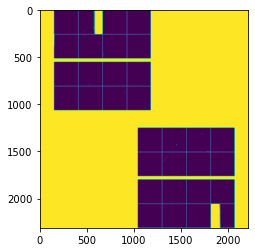

In [40]:
jfmask = np.load('JFMask.npy')
Quarter1, Quarter2, Quarter3, Quarter4 = parameters.Quarter1, parameters.Quarter2, parameters.Quarter3, parameters.Quarter4
print(Quarter1.dtype)

three_quarter_mask = jfmask|(~(Quarter1|Quarter3|Quarter4))
two_quarter_mask = jfmask|~(Quarter1|Quarter4)
plt.imshow(two_quarter_mask)

In [15]:
# 500uJ 
Delay_Steps1 = [100*i for i in range(21)]
Acq_File1 = '/sf/maloja/data/p19750/work/analysis/zhibin/CoreShell/Run_0368.h5'
Bkg_File1 = '/sf/maloja/data/p19750/work/analysis/zhibin/CoreShell/BG_Run_0368.h5'
Delay_Steps2 = [-20+10*i for i in range(23)]
Acq_File2 = '/sf/maloja/data/p19750/work/analysis/zhibin/CoreShell/Run_0370.h5'
Bkg_File2 = '/sf/maloja/data/p19750/work/analysis/zhibin/CoreShell/BG_Run_0370.h5'
Delay_Steps3 = [-3+1*i for i in range(34)]
Acq_File3 = '/sf/maloja/data/p19750/work/analysis/zhibin/CoreShell/Run_0374.h5'
Bkg_File3 = '/sf/maloja/data/p19750/work/analysis/zhibin/CoreShell/BG_Run_0374.h5'
Delay_Steps4 = [-1+0.1*i for i in range(31)]
Acq_File4 = '/sf/maloja/data/p19750/work/analysis/zhibin/CoreShell/Run_0375.h5'
Bkg_File4 = '/sf/maloja/data/p19750/work/analysis/zhibin/CoreShell/BG_Run_0375.h5'

Delay_Steps = np.array(Delay_Steps1 + Delay_Steps2 + Delay_Steps3 + Delay_Steps4)
sorted_step_indices = np.argsort(Delay_Steps) # small to large
Delay_Steps_sorted = Delay_Steps[sorted_step_indices]

In [16]:
Acq_Files = [Acq_File1, Acq_File2, Acq_File3, Acq_File4]
Bkg_Files = [Bkg_File1, Bkg_File2, Bkg_File3, Bkg_File4]
Steps = [Delay_Steps1, Delay_Steps2, Delay_Steps3, Delay_Steps4]

# Acq_Files = [Acq_File1]
# Bkg_Files = [Bkg_File1]
# Steps = [Delay_Steps1]


# print(f'Acquisition file: {Acq_File}')
Bkg = 0 # initialization
with h5py.File(Bkg_File2, 'r') as bkgs:
    Bkg = np.array(bkgs['/bg/image']).mean(0)

with h5py.File(Acq_File2, 'r') as acq:
    num_steps = acq['/LXT/LXT_Scan'].shape[0]

    pattern_str = '/jungfrau/pattern_' + str(3)
    jf_images = CMC.ComModCor(np.array(acq[pattern_str]) - Bkg)[0]


center shift (Δy, Δx) = [3 6]
center shift: [3 6]
(61, 61)


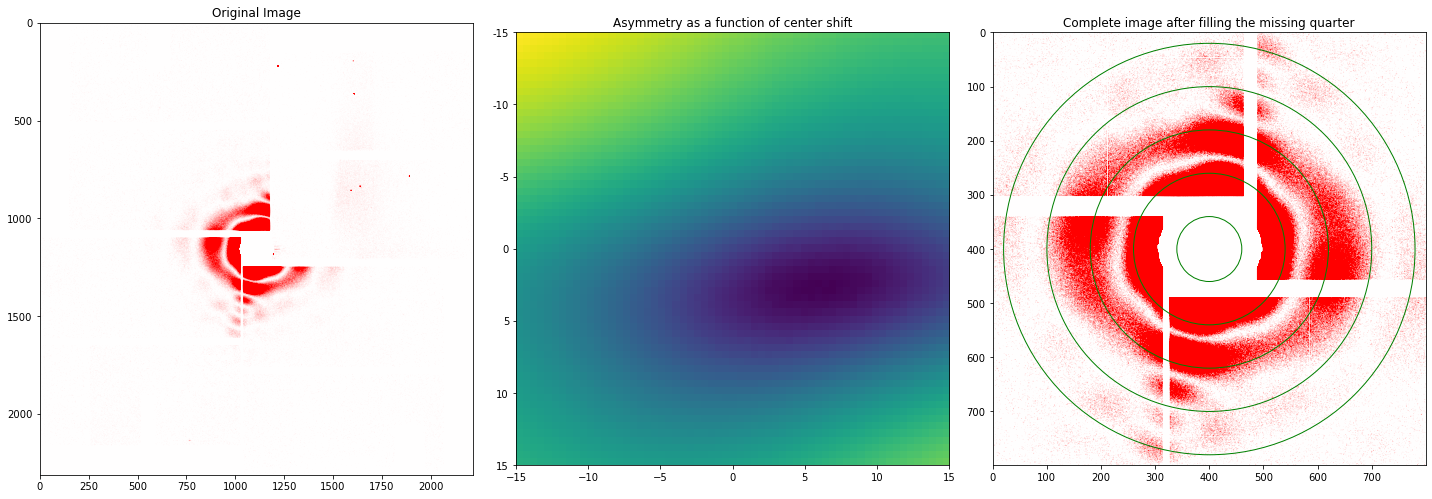

center shift (Δy, Δx) = [1 3]
center shift: [1 3]
(61, 61)


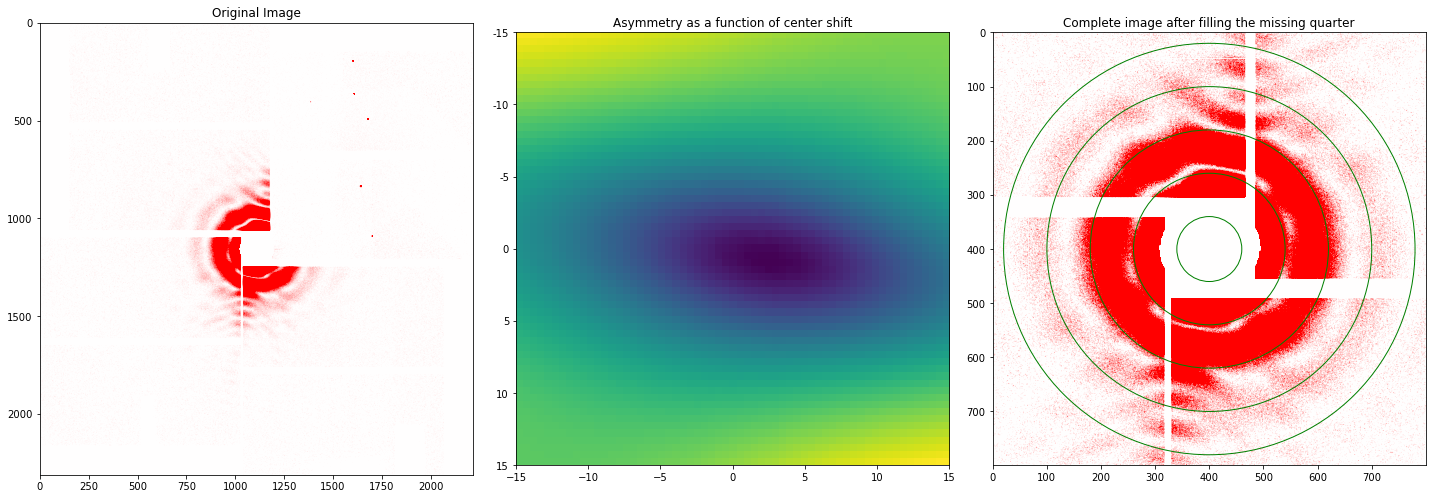

center shift (Δy, Δx) = [1 7]
center shift: [1 7]
(61, 61)


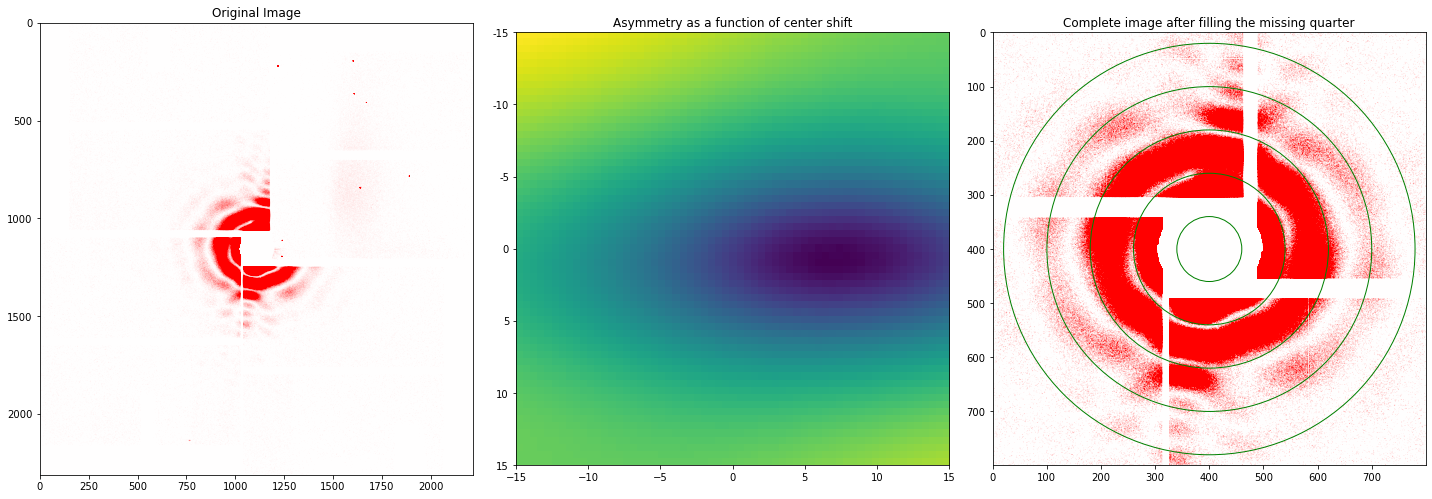

center shift (Δy, Δx) = [2 7]
center shift: [2 7]
(61, 61)


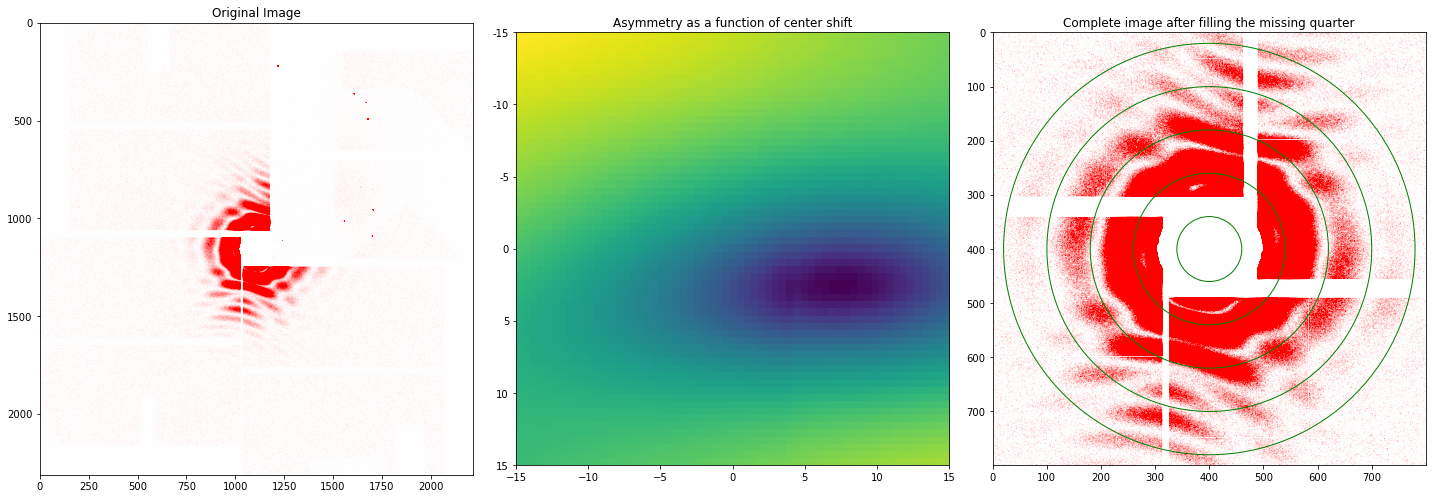

0.0010870753825364962
Abandon image 4 because it is so weak
0.0011931077038437204
Abandon image 5 because it is so weak
0.0011550297984018996
Abandon image 6 because it is so weak
0.001110507939731463
Abandon image 7 because it is so weak
0.0011522960000624868
Abandon image 8 because it is so weak
center shift (Δy, Δx) = [-2  7]
center shift: [-2  7]
(61, 61)


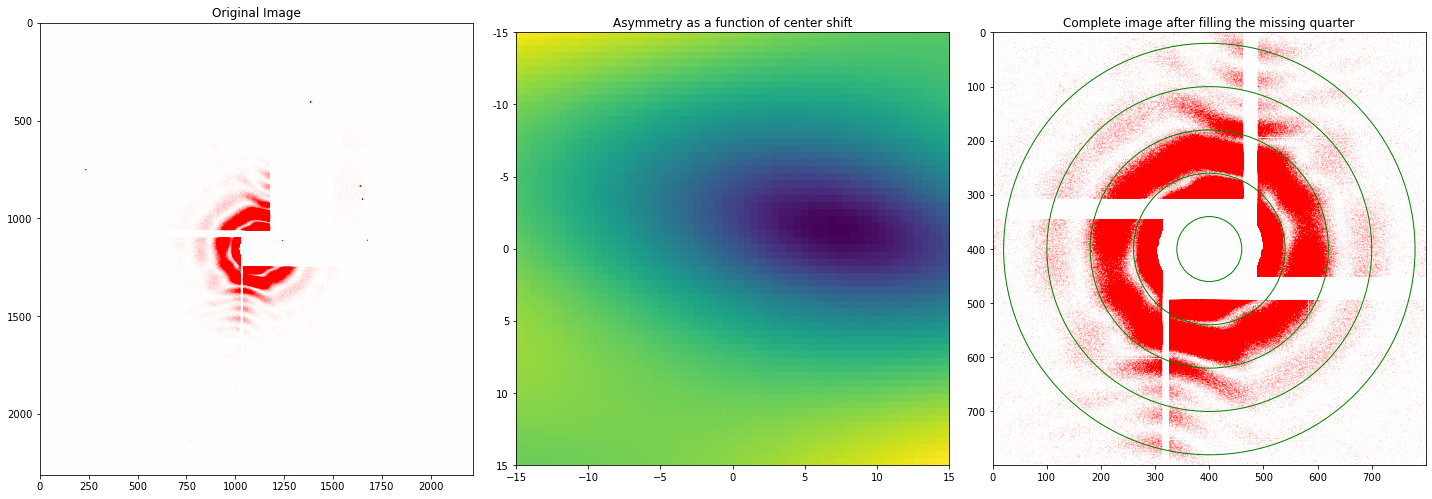

0.010245690362189227
Abandon image 10 because it is so weak
center shift (Δy, Δx) = [ 2 12]
center shift: [ 2 12]
(61, 61)


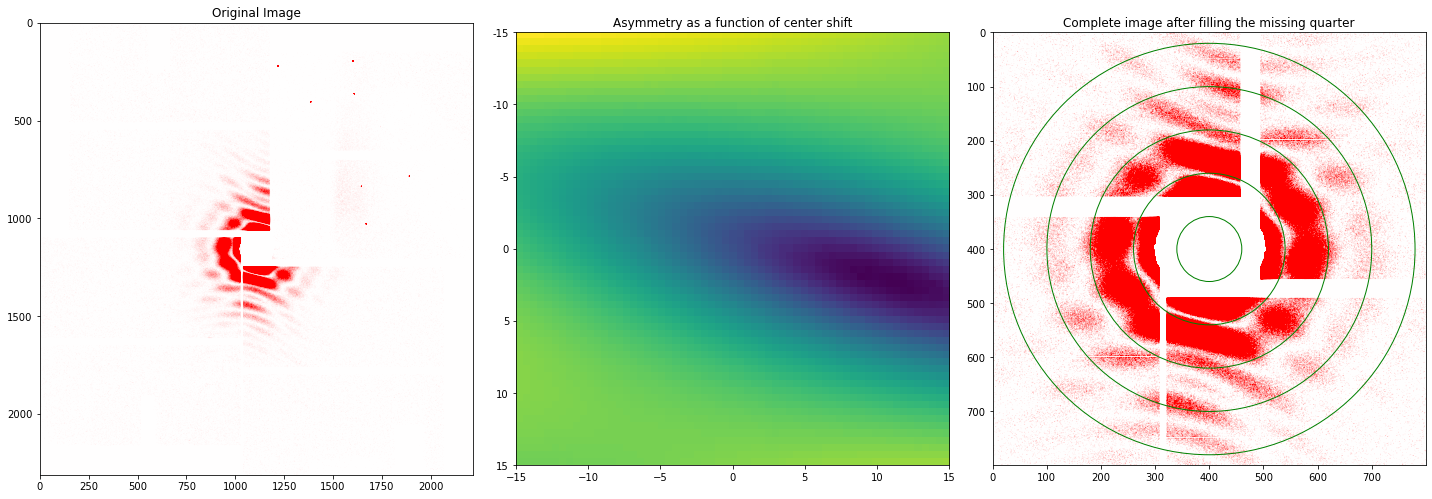

0.01555531255125872
Abandon image 12 because it is so weak
0.017913604161622156
Abandon image 13 because it is so weak
center shift (Δy, Δx) = [0 8]
center shift: [0 8]
(61, 61)


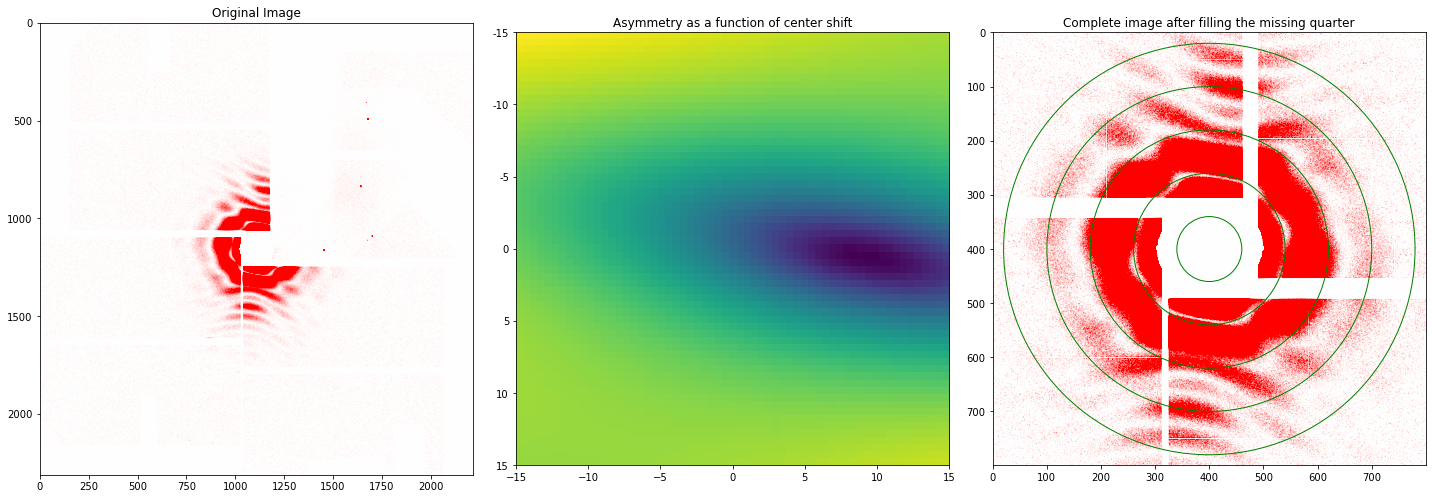

center shift (Δy, Δx) = [-1 13]
center shift: [-1 13]
(61, 61)


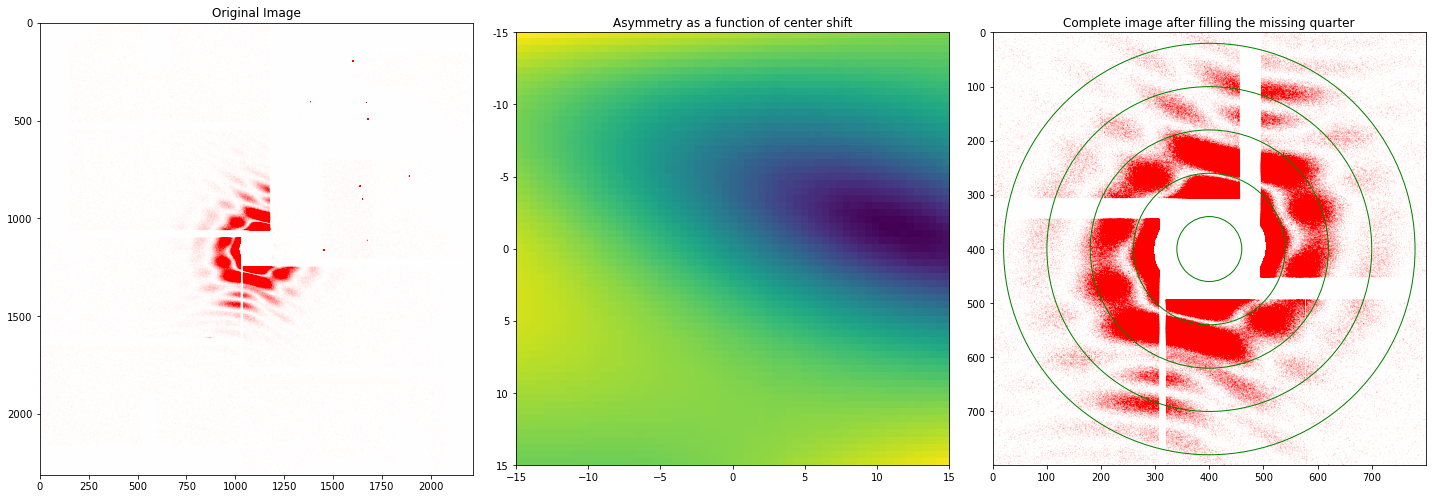

0.0009855343013583072
Abandon image 16 because it is so weak
0.0012030665406515813
Abandon image 17 because it is so weak
center shift (Δy, Δx) = [ 0 11]
center shift: [ 0 11]
(61, 61)


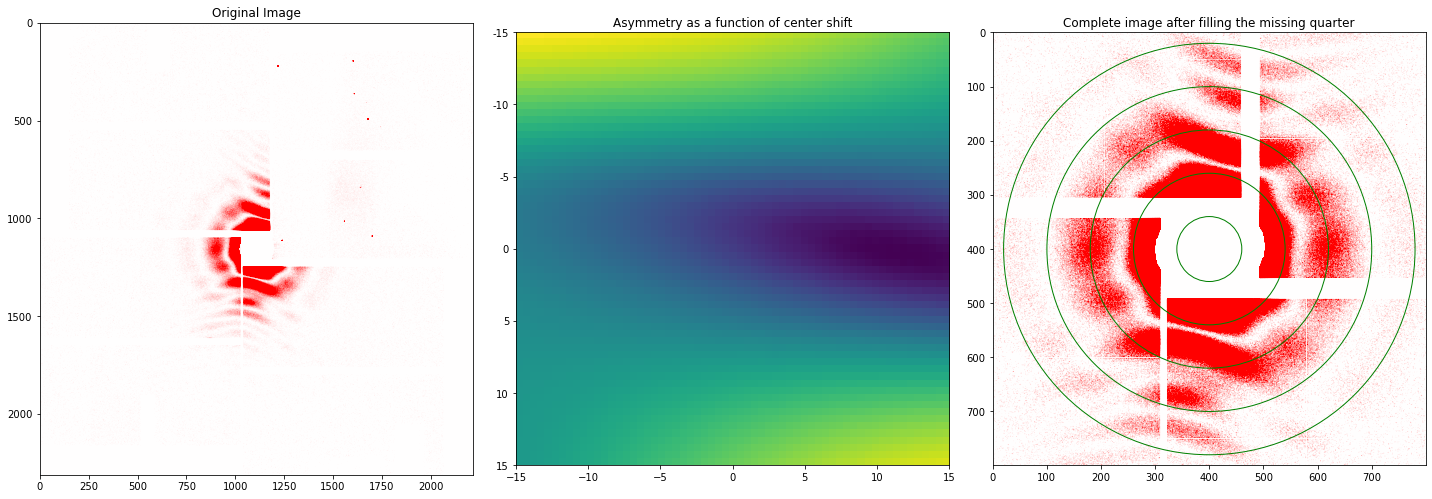

0.0009533145352152281
Abandon image 19 because it is so weak
0.0010851226694369156
Abandon image 20 because it is so weak
0.0011136322806907918
Abandon image 21 because it is so weak


In [63]:
Area = jf_images.shape[1]*jf_images.shape[2]
for i, jf_image in enumerate(jf_images):
    gt1 = np.sum(jf_image > 1)/Area
    if  gt1 < 0.02:
        print(gt1)
        print(f'Abandon image {i} because it is so weak')
        continue

    bad_pix_mask2 = bad_pixel.abnormal_pixels(jf_image, jfmask)
    temp_mask = bad_pix_mask2|three_quarter_mask
    processed = jf_image*(~temp_mask)
    asymmetry, center_shift = find_center.Auto_Find_Center(processed, temp_mask)

    print(f'center shift (Δy, Δx) = {center_shift}')
    center = np.array([1155, 1105]) + center_shift
    complete_img = fill_quarter(jf_image*(~temp_mask), center = center)

    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 7))  # Adjust figsize for better layout
    
    # Plot data on each subplot
    axs[0].imshow(jf_image, cmap='bwr', vmin = -3, vmax = 3)
    axs[0].set_title("Original Image")
    print(asymmetry.shape)
    axs[1].imshow(np.log(asymmetry), extent=[-15, 15, -15, 15])
    axs[1].set_xticks(np.arange(-15, 16, 5))
    axs[1].set_yticks(np.arange(-15, 16, 5))
    axs[1].set_yticklabels(np.arange(-15, 16, 5)[::-1])     # Reverse the labels on the y-axis

    axs[1].set_title("Asymmetry as a function of center shift")
    
    
    Cropsize = 801
    img_center_y, img_center_x = center
    # print(f'center: {center}')
    half_cropsize = Cropsize // 2

    # Calculate cropping boundaries to keep the image center
    x_start = max(img_center_x - half_cropsize, 0)
    x_end = min(img_center_x + half_cropsize, complete_img.shape[1])
    y_start = max(img_center_y - half_cropsize, 0)
    y_end = min(img_center_y + half_cropsize, complete_img.shape[0])

    # Crop the image
    cropped_img = complete_img[y_start:y_end, x_start:x_end]

    # Adjust center for cropping boundaries
    circle_center_y, circle_center_x = np.array([Cropsize, Cropsize])//2
    Num_Circ = 5
    
    axs[2].imshow(cropped_img, cmap='bwr', vmin = -3, vmax = 3)
    # axs[2].autoscale()
    axs[2].set_title("Complete image after filling the missing quarter")

    for i in range(Num_Circ):
        radius = half_cropsize * (Num_Circ - i) / Num_Circ - 20
        circle = plt.Circle((circle_center_y, circle_center_x), radius, color='green', fill=False)
        axs[2].add_patch(circle)
    
    # Adjust layout for better spacing
    plt.tight_layout()
    
    # Show the plot
    plt.show()
